# Imports

In [ ]:
import zipfile
import os
import random
from pathlib import Path
import pandas as pd
import xml.etree.ElementTree as ET
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

# Reading Input Files

In [ ]:
def zip2dir(input_zip, output_dir):
    # Ensure the directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Open the zip file
    with zipfile.ZipFile(input_zip, 'r') as zip_ref:
        # Extract all files
        zip_ref.extractall(output_dir)

> Unzipping input files

In [ ]:
annot_dir = "Annotation/"
all_dogs = "all-dogs/"

zip2dir("/kaggle/input/generative-dog-images/Annotation.zip", "./")
zip2dir("/kaggle/input/generative-dog-images/all-dogs.zip", "./")

> Reading input files directories

In [ ]:
all_dogs_files = [Path(all_dogs+i) for i in os.listdir(all_dogs)]
annot_files = [file for file in Path(annot_dir).rglob("*") if file.is_file()]

print(f"all_dogs_files: {all_dogs_files[:5]}")
print(f"annot_files: {annot_files[:5]}")

> Creating DataFrame

In [ ]:
tmp_map = {i.name: str(i) for i in annot_files}
input_file_dict = {str(i): tmp_map[i.stem] for i in all_dogs_files}

In [ ]:
data = []

for k,v in input_file_dict.items():
    # Load and parse the XML file
    tree = ET.parse(v)  # Replace 'file.xml' with the path to your file
    root = tree.getroot()
    
    # Extract metadata
    folder = root.find('folder').text
    filename = root.find('filename').text
    database = root.find('source/database').text
    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text
    depth = size.find('depth').text
    
    # Extract object details and add metadata for each object
    for obj in root.findall('object'):
        name = obj.find('name').text
        pose = obj.find('pose').text
        truncated = obj.find('truncated').text
        difficult = obj.find('difficult').text
        bndbox = obj.find('bndbox')
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
    
        # Add a row for each object
        data.append({
            "ImageDirectory": k,
            "AnnotationDirectory": v,
            'Folder': folder,
            'Filename': filename,
            'Database': database,
            'Width': width,
            'Height': height,
            'Depth': depth,
            'ObjectName': name,
            'Pose': pose,
            'Truncated': truncated,
            'Difficult': difficult,
            'XMin': xmin,
            'YMin': ymin,
            'XMax': xmax,
            'YMax': ymax
        })

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.head()

> Little EDA

In [ ]:
# General info about the DataFrame
print(df.info())

# Summary statistics of numeric columns
print(df.describe())

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Find unique values in categorical columns
for col in ['Folder', 'Database', 'ObjectName', 'Pose']:
    print(f"Unique values in {col}: {df[col].unique()}")

In [ ]:
# Count occurrences of each object name
object_counts = df['ObjectName'].value_counts()
print(object_counts)

# Plot the distribution
object_counts.plot(kind='bar', title='Object Name Distribution', figsize=(16, 6))

In [ ]:
df['XCenter'] = (df['XMin'].astype(int) + df['XMax'].astype(int)) / 2
df['YCenter'] = (df['YMin'].astype(int) + df['YMax'].astype(int)) / 2

# Plot centers
import matplotlib.pyplot as plt

plt.scatter(df['XCenter'], df['YCenter'], alpha=0.5)
plt.title('Bounding Box Centers')
plt.xlabel('XCenter')
plt.ylabel('YCenter')
plt.show()

In [ ]:
import torchvision.io as io

def denormalize(tensor, mean, std):
    """
    Denormalize a normalized tensor image back to the [0, 1] range for visualization.
    Args:
        tensor (torch.Tensor): The normalized image tensor.
        mean (list): Mean values used for normalization (per channel).
        std (list): Standard deviation values used for normalization (per channel).
    Returns:
        torch.Tensor: Denormalized image tensor in range [0, 1].
    """
    # Input validation
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a torch.Tensor")
    if tensor.dim() != 3:
        raise ValueError("Input must be a 3D tensor (C,H,W)")
        
    # Convert to float if needed
    tensor = tensor.float()
    
    # Reshape mean and std for broadcasting
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
    
    # Denormalize
    tensor = tensor * std + mean
    
    # Clamp values to [0, 1] range
    tensor = torch.clamp(tensor, 0, 1)
    
    return tensor

def show_image(image_path, denorm=False, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Display a single image given its path.
    Args:
        image_path (str): Path to the image file.
        denorm (bool): Whether to denormalize the image.
        mean (list): Mean values used for normalization.
        std (list): Standard deviation values used for normalization.
    """
    try:
        # Read image and convert to float
        img = io.read_image(image_path).float()
        
        # Normalize to [0, 1] range
        if img.max() > 1.0:
            img = img / 255.0
            
        # Apply denormalization if requested
        if denorm:
            img = denormalize(img, mean, std)
        
        # Convert to numpy and display
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        plt.title(image_path.split('/')[-1])
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")

# Example usage
random_image_path = df.sample().iloc[0]['ImageDirectory']
show_image(random_image_path)

## Analyzing BBoxes

In [ ]:
# Assuming `df` is your DataFrame
df['XMin'] = pd.to_numeric(df['XMin'], errors='coerce')
df['XMax'] = pd.to_numeric(df['XMax'], errors='coerce')
df['YMin'] = pd.to_numeric(df['YMin'], errors='coerce')
df['YMax'] = pd.to_numeric(df['YMax'], errors='coerce')
df['BoundingBoxArea'] = (df['XMax'] - df['XMin']) * (df['YMax'] - df['YMin'])

In [ ]:
df.to_csv("data.csv", index=False)

In [ ]:
# Convert relevant columns to numeric types
columns_to_convert = ['XMax', 'XMin', 'YMax', 'YMin', 'BoundingBoxArea', 'Width', 'Height',]
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Remove rows with invalid numeric data
bbox_data = df.dropna(subset=columns_to_convert)

# Extract bounding box dimensions
bbox_widths = bbox_data['XMax'] - bbox_data['XMin']
bbox_heights = bbox_data['YMax'] - bbox_data['YMin']
bbox_areas = bbox_data['BoundingBoxArea']
image_widths = bbox_data['Width']
image_heights = bbox_data['Height']

# Summarize statistics
summary = {
    "Bounding Box Widths": {
        "Min": bbox_widths.min(),
        "Max": bbox_widths.max(),
        "Mean": bbox_widths.mean(),
        "Median": bbox_widths.median(),
        "StdDev": bbox_widths.std()
    },
    "Bounding Box Heights": {
        "Min": bbox_heights.min(),
        "Max": bbox_heights.max(),
        "Mean": bbox_heights.mean(),
        "Median": bbox_heights.median(),
        "StdDev": bbox_heights.std()
    },
    "Image Widths": {
        "Min": image_widths.min(),
        "Max": image_widths.max(),
        "Mean": image_widths.mean(),
        "Median": image_widths.median(),
        "StdDev": image_widths.std()
    },
    "Image Heights": {
        "Min": image_heights.min(),
        "Max": image_heights.max(),
        "Mean": image_heights.mean(),
        "Median": image_heights.median(),
        "StdDev": image_heights.std()
    }
}

# Convert the summary to a DataFrame
summary_df = pd.DataFrame(summary)

# Display statistics
print("Bounding Box and Image Statistics:")
print(summary_df)

# Plot histograms for bounding boxes and image dimensions
plt.figure(figsize=(18, 10))

# Bounding box widths
plt.subplot(2, 2, 1)
plt.hist(bbox_widths, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bounding Box Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Bounding box heights
plt.subplot(2, 2, 2)
plt.hist(bbox_heights, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Bounding Box Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

# Image widths
plt.subplot(2, 2, 3)
plt.hist(image_widths, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.title('Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Image heights
plt.subplot(2, 2, 4)
plt.hist(image_heights, bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Decision on Image Dimension Selection

After analyzing the statistics and distributions of bounding box widths, heights, and image dimensions, I have decided to standardize the image dimension to **256 pixels**. This decision is based on the following considerations:

1. **Divisibility by 2**: A dimension of 256 is divisible by 2 repeatedly, making it highly compatible with deep learning architectures that often involve downsampling operations.
2. **Ease of Handling**: 256 pixels is a manageable size that balances computational efficiency and sufficient detail retention for the task.
3. **Consistency**: Standardizing dimensions ensures uniformity in data preprocessing, improving the model's performance and interpretability.

This standardized dimension will be used for resizing all images before processing them further.

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch

# Directories for saving images
os.makedirs("original_images", exist_ok=True)
os.makedirs("augmented_images", exist_ok=True)

# Define normalization parameters
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

# Transforms
crop_transform = transforms.Compose([
    transforms.Resize((256, 256))  # Crop and resize centered at BBox
])

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2.0)),  # Added blur
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)  # Apply normalization
])

def denormalize(tensor):
    """
    Denormalize a tensor image with fixed mean and std
    """
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)  # Clamp to [0,1] range

# DataFrame to store results
result = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row['ImageDirectory']
    object_name = row['ObjectName']
    x_center, y_center = row['XCenter'], row['YCenter']
    width, height = row['Width'], row['Height']
    bbox_width, bbox_height = row['XMax'] - row['XMin'], row['YMax'] - row['YMin']
    
    try:
        # Open and crop image
        img = Image.open(img_path).convert("RGB")
        left = max(0, x_center - bbox_width // 2)
        upper = max(0, y_center - bbox_height // 2)
        right = min(width, x_center + bbox_width // 2)
        lower = min(height, y_center + bbox_height // 2)
        cropped_img = img.crop((left, upper, right, lower)).resize((256, 256))
        
        # Save original cropped image
        original_path = f"original_images/{os.path.basename(img_path)}"
        cropped_img.save(original_path)
        
        # Apply augmentations
        aug_img = augment_transform(cropped_img)  # Returns normalized tensor
        
        # Denormalize before saving
        aug_img_denorm = denormalize(aug_img)
        
        # Convert to PIL and save
        aug_img_pil = transforms.ToPILImage()(aug_img_denorm)
        augmented_path = f"augmented_images/{os.path.basename(img_path)}"
        aug_img_pil.save(augmented_path)
        
        # Append to result DataFrame
        result.append({
            "OriginalImagePath": original_path,
            "AugmentedImagePath": augmented_path,
            "ObjectName": object_name
        })
        
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue

# Create DataFrame
final_df = pd.DataFrame(result)
final_df.to_csv("image_paths.csv", index=False)
print("Processing complete! Data saved in 'image_paths.csv'.")

# Function to view results
def view_pair(row_idx, final_df):
    """
    Display original and augmented image pair
    """
    import matplotlib.pyplot as plt
    
    row = final_df.iloc[row_idx]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display original
    img1 = Image.open(row['OriginalImagePath'])
    ax1.imshow(img1)
    ax1.set_title('Original')
    ax1.axis('off')
    
    # Display augmented
    img2 = Image.open(row['AugmentedImagePath'])
    ax2.imshow(img2)
    ax2.set_title('Augmented')
    ax2.axis('off')
    
    plt.show()

# View a random pair
random_idx = np.random.randint(len(final_df))
view_pair(random_idx, final_df)

In [ ]:
final_df

In [ ]:
final_df.to_csv('final_df.csv', index=False)

In [ ]:
# View a random pair
random_idx = np.random.randint(len(final_df))
view_pair(random_idx, final_df)

# Building Model
This section outlines the steps to build a Conditional Variational Autoencoder (C-VAE) for generating new dog images using PyTorch.

In [12]:
import torch
from torch import nn
import torchvision

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # Optional downsample layer for dimension matching

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)  # Adjust identity to match output dimensions

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.silu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Residual connection
        out = self.silu(out)
        return out

class ResidualBlockDecoder(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlockDecoder, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(x + self.block(x))
        

class Encoder(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        # Initial convolution and pooling
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ) # [3, 256, 256] -> [64, 64, 64]

        self.layers = nn.ModuleList()
        
        # Residual layers configuration
        layer_configs = [
            (64, 64, 3, 1),    # [64, 64, 64] 
            (64, 128, 4, 2),   # [128, 32, 32]
            (128, 256, 6, 2),  # [256, 16, 16]
            (256, 512, 3, 2)   # [512, 8, 8]
        ]
        
        self.layers = self._make_layers(layer_configs)
        
        self.conv_final = nn.Conv2d(512, latent_dim * 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn_final = nn.BatchNorm2d(latent_dim * 2)

    def _make_layers(self, configs):
        layers = []
        for in_channels, out_channels, num_blocks, stride in configs:
            downsample = None
            if stride != 1 or in_channels != out_channels:
                # Downsample to match dimensions for residual connection
                downsample = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
            layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))  # First block with downsample
            for _ in range(1, num_blocks):
                layers.append(ResidualBlock(out_channels, out_channels))  # Subsequent blocks
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layers(x)
        x = self.conv_final(x)
        x = self.bn_final(x)
        return x[:, :self.latent_dim, :, :], x[:, self.latent_dim:, :, :]


class Decoder(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.feature_dim = feature_dim
        self.latent_dim  = latent_dim

        # Initial upscaling layer
        self.initial_layer = nn.Sequential(
            nn.Conv2d(latent_dim, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU()
        )  # [latent_dim, 4, 4] -> [256, 4, 4]

        # Upscaling layers with residual blocks
        self.up_blocks = nn.ModuleList([
            self._make_up_block(256, 128),  # [256, 4, 4] -> [128, 8, 8]
            self._make_up_block(128, 64),  # [128, 8, 8] -> [64, 16, 16]
            self._make_up_block(64, 32),  # [64, 16, 16] -> [32, 32, 32]
            self._make_up_block(32, 16),  # [32, 32, 32] -> [16, 64, 64]
            self._make_up_block(16, 8),   # [16, 64, 64] -> [8, 128, 128]
            self._make_up_block(8, 4)     # [8, 128, 128] -> [4, 256, 256]
        ])

        
        # Final convolution layer
        self.final_layer = nn.Sequential(
            nn.Conv2d(4, self.in_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Outputs in range [-1, 1]
        )
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
            ResidualBlockDecoder(out_channels),  
            ResidualBlockDecoder(out_channels)
        )
        
    def forward(self, x):
        x = self.initial_layer(x)
        for block in self.up_blocks:
            x = block(x)
        x = self.final_layer(x)
        return x


class VAE(nn.Module):
    def __init__(self, in_channels, feature_dim, latent_dim, cond_dim, n_conditions):
        super(VAE, self).__init__()
        self.in_channels = in_channels
        self.feature_dim = feature_dim      
        self.latent_dim  = latent_dim

        self.encoder = Encoder(in_channels, feature_dim, latent_dim)
        self.decoder = Decoder(in_channels, feature_dim, latent_dim + cond_dim)

        # Learnable embeddings for conditions
        self.condition_embeddings = nn.Embedding(n_conditions, cond_dim)
        self.condition_ffn = nn.Linear(cond_dim, cond_dim)
        self.silu = nn.SiLU()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x, condition):
        mu, logvar = self.encoder(x)
        # Reparametrizing trick
        z = self.reparameterize(mu, logvar)

        # Add condition embedding
        cond_embedding = self.condition_ffn(self.condition_embeddings(condition).squeeze())
        cond_embedding = self.silu(cond_embedding)
        cond_embedding = cond_embedding.unsqueeze(-1).unsqueeze(-1)  # (batch_size, cond_dim, 1, 1)
        if len(cond_embedding.shape) == 3: cond_embedding = cond_embedding.unsqueeze(0)
        cond_embedding = cond_embedding.expand(-1, -1, 4, 4)  # Expand for concatenation
        
        z_cond = torch.cat([z, cond_embedding], dim=1)
        # Decode
        reconstructed = self.decoder(z_cond)
        return reconstructed, mu, logvar

In [13]:
a=nn.Conv2d(3, 5, 3, 2, 1)
a(torch.rand(2, 3, 256, 256)).shape

torch.Size([2, 5, 128, 128])

In [14]:
model = VAE(3, 256, 128, 16, 10)
model(torch.rand(2, 3, 256, 256), torch.tensor([[1], [5]]))[0].shape

torch.Size([2, 3, 256, 256])

In [15]:
recon_batch, mu, logvar = model(torch.rand(2, 3, 256, 256), torch.tensor([[1], [5]]))
-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / 2

tensor(1671.3674, grad_fn=<DivBackward0>)

In [16]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import random
import torch.nn.functional as F

class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None, include_augmented=False):
        """
        Args:
            df: DataFrame with image paths and conditions (ObjectName)
            transform: Optional transforms to apply
            include_augmented: Whether to include augmented images
        """
        # Handle original and augmented data
        self.image_paths = df['OriginalImagePath'].tolist()
        self.aug_image_paths = df['AugmentedImagePath'].tolist()
        self.conditions = df['ObjectName'].tolist()
        self.include_augmented = include_augmented
        # Create condition encoder
        unique_conditions = sorted(set(self.conditions))
        self.condition_to_idx = {cond: idx for idx, cond in enumerate(unique_conditions)}
        self.num_conditions = len(unique_conditions)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        if self.include_augmented:
            aug = random.random() < 0.2
            if aug:
                image_path = self.aug_image_paths[idx]
            else:
                image_path = self.image_paths[idx]
        else:
            image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        target_image = Image.open(self.image_paths[idx]).convert('RGB')

        # Get condition
        condition = self.conditions[idx]
        condition_idx = self.condition_to_idx[condition]
        
        if self.transform:
            image = self.transform(image)
            target_image = self.transform(target_image)

        return image, torch.tensor(condition_idx, dtype=torch.long), target_image

In [17]:
def prepare_data(csv_path, batch_size=32):
    # Read the CSV
    df = pd.read_csv(csv_path)
    
    # Create train/val split (80/20)
    train_size = int(0.8 * len(df))
    train_df = df.iloc[:train_size]
    val_df = df.iloc[train_size:]
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    # Create datasets
    train_dataset = CustomImageDataset(train_df, transform=transform, include_augmented=True)
    val_dataset = CustomImageDataset(val_df, transform=transform, include_augmented=False)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, val_loader, train_dataset.num_conditions

In [18]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import clear_output
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

def plot_losses(train_losses, val_losses):
    """Plot training progress"""
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Total loss
    ax1.plot([x['total'] for x in train_losses], label='Train')
    ax1.plot([x['total'] for x in val_losses], label='Val')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    
    # Reconstruction loss
    ax2.plot([x['recon'] for x in train_losses], label='Train')
    ax2.plot([x['recon'] for x in val_losses], label='Val')
    ax2.set_title('Reconstruction Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    
    # KL loss
    ax3.plot([x['kl'] for x in train_losses], label='Train')
    ax3.plot([x['kl'] for x in val_losses], label='Val')
    ax3.set_title('KL Loss')
    ax3.set_xlabel('Epoch')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

In [19]:
df = pd.read_csv('final_df.csv')

In [20]:
a=df.head().iloc[0]

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
image = Image.open(a['OriginalImagePath']).convert('RGB')
target_image = Image.open(a['AugmentedImagePath']).convert('RGB')

In [22]:
image = transform(image)
target_image = transform(target_image)

In [23]:
model.to('cpu')
recon_batch, mu, logvar = model(image.unsqueeze(0), torch.tensor([[1]]))

In [24]:
print(recon_batch.min())
print(recon_batch.max())

tensor(-1., grad_fn=<MinBackward1>)
tensor(1.0000, grad_fn=<MaxBackward1>)


In [25]:
print(image.min())
print(image.max())
print(target_image.min())
print(target_image.max())

tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)


In [26]:
target_image

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [27]:
recon_batch

tensor([[[[ 6.3576e-02, -1.3603e-02,  1.8350e-02,  ..., -2.7258e-02,
           -2.7317e-02, -2.3182e-02],
          [-6.2578e-02, -2.7597e-02, -7.7652e-03,  ..., -2.5589e-02,
           -3.8850e-02, -2.4623e-03],
          [-3.5715e-02, -7.2796e-02,  5.3920e-03,  ...,  2.9687e-03,
           -2.1529e-02,  7.7932e-03],
          ...,
          [-2.2985e-02, -6.4705e-02,  1.1185e-02,  ..., -2.1665e-03,
           -7.1723e-03,  6.7927e-05],
          [-2.0989e-02, -3.4872e-02,  1.8229e-02,  ...,  1.6826e-02,
           -3.9795e-03, -3.6981e-03],
          [-6.8166e-02, -4.9566e-02, -2.2689e-02,  ..., -2.1061e-02,
           -8.9473e-03,  1.2296e-02]],

         [[-4.0767e-03, -1.3632e-01, -2.3022e-02,  ...,  3.6015e-03,
            7.9097e-02,  4.8122e-02],
          [ 1.2945e-01,  5.3263e-02,  1.1050e-01,  ...,  1.4707e-01,
            1.8054e-01,  8.1928e-02],
          [ 7.9787e-02, -8.9261e-02,  6.0396e-02,  ...,  1.5765e-02,
            9.7156e-02,  4.9424e-02],
          ...,
     

In [50]:
import matplotlib.pyplot as plt
MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]
def denormalize(tensor):
    """
    Denormalize a tensor image with fixed mean and std
    """
    tensor = tensor.clone()  # Avoid modifying the original tensor
    for t, m, s in zip(tensor, MEAN, STD):
        t.mul_(s).add_(m)
    return tensor.clamp_(0, 1)  # Clamp to [0,1] range
    
def train_vae(model, train_loader, val_loader, epochs=100, device='cuda', batch_size=32, n_conditions=120):
    # Loss function
    reconstruction_loss = nn.MSELoss()
    
    # Optimizer with adjusted learning rate
    optimizer = optim.AdamW(model.parameters(), lr=5e-4,)
    # scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Move model to device
    model = model.to(device)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    fixed_z = torch.randn(1, model.latent_dim, 4, 4).to(device)
    fixed_cond = torch.randint(0, n_conditions, (1,1,)).to(device)
    val_iter = iter(val_loader)
    val_samples, val_conditions, val_targets = next(val_iter)
    val_samples = val_samples[:2].to(device)  # Pick first two images
    val_conditions = val_conditions[:2].to(device)
    val_targets = val_targets[:2].to(device)
    fixed_val_samples = (val_samples, val_conditions, val_targets)
    beta_start = 1.0
    beta_end = 1.0
    betas = torch.linspace(beta_start, beta_end, epochs)
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training phase
        model.train()
        train_loss = 0
        train_recon_loss = 0
        train_kl_loss = 0
        beta = betas[epoch]
        print("Current beta is:", beta)
        
        train_pbar = tqdm(train_loader, leave=False, desc=f'Training Epoch {epoch+1}')
        for batch_idx, (data, condition, target) in enumerate(train_pbar):
            data, condition, target = data.to(device), condition.to(device), target.to(device)
            batch_size = data.size(0)
            
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = model(data, condition)
            
            # Compute losses with proper scaling
            recon_loss = reconstruction_loss(recon_batch, target)
            # KL loss with proper reduction
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Total loss with adjusted beta
            # beta = 0.1  # Much smaller beta to focus on reconstruction first
            
            
            loss = recon_loss + beta * kl_loss
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate losses
            train_loss += loss.item() * batch_size
            train_recon_loss += recon_loss.item() * batch_size
            train_kl_loss += kl_loss.item() * batch_size
            
            train_pbar.set_postfix({
                'loss': loss.item(),
                'recon': recon_loss.item(),
                'kl': kl_loss.item()
            })
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_recon_loss = 0
        val_kl_loss = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, leave=False, desc=f'Validation Epoch {epoch+1}')
            for data, condition, target in val_pbar:
                data, condition, target = data.to(device), condition.to(device), target.to(device)
                batch_size = data.size(0)
                
                recon_batch, mu, logvar = model(data, condition)
                
                # Compute losses
                recon_loss = reconstruction_loss(recon_batch, target)

                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                
                loss = recon_loss + beta * kl_loss
                
                val_loss += loss.item() * batch_size
                val_recon_loss += recon_loss.item() * batch_size
                val_kl_loss += kl_loss.item() * batch_size
                
                val_pbar.set_postfix({
                    'loss': loss.item(),
                    'recon': recon_loss.item(),
                    'kl': kl_loss.item()
                })
        
        # scheduler.step()
        
        # Calculate average losses
        train_size = len(train_loader.dataset)
        val_size = len(val_loader.dataset)
        
        avg_train_loss = train_loss / train_size
        avg_train_recon = train_recon_loss / train_size
        avg_train_kl = train_kl_loss / train_size
        
        avg_val_loss = val_loss / val_size
        avg_val_recon = val_recon_loss / val_size
        avg_val_kl = val_kl_loss / val_size
        
        # Store losses for plotting
        train_losses.append({
            'total': avg_train_loss,
            'recon': avg_train_recon,
            'kl': avg_train_kl
        })
        val_losses.append({
            'total': avg_val_loss,
            'recon': avg_val_recon,
            'kl': avg_val_kl
        })
        
        if (epoch + 1) % 5 == 0:
            plot_losses(train_losses, val_losses)
            
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                # 'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_val_loss,
                'condition_to_idx': train_loader.dataset.condition_to_idx  # Save mapping
            }, 'best_model.pth')
        
        print(f'Epoch {epoch+1}:')
        print(f'Train Loss: {avg_train_loss:.4f} (Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f})')
        print(f'Valid Loss: {avg_val_loss:.4f} (Recon: {avg_val_recon:.4f}, KL: {avg_val_kl:.4f})')
        print('-' * 50)
        with torch.no_grad():
            plt.figure(figsize=(20, 4))
            
            cond_embedding = model.condition_ffn(model.condition_embeddings(fixed_cond).squeeze())
            cond_embedding = model.silu(cond_embedding)
            cond_embedding = cond_embedding.unsqueeze(-1).unsqueeze(-1).unsqueeze(0)  # (batch_size, cond_dim, 1, 1)
            cond_embedding = cond_embedding.expand(-1, -1, 4, 4)  # Expand for concatenation
            
            z_cond = torch.cat([fixed_z, cond_embedding], dim=1)
            # Decode
            generated = model.decoder(z_cond)
            generated = denormalize(generated)
            # Convert to image
            img = generated.squeeze().cpu().numpy().transpose(1, 2, 0)
            
            # Plot
            plt.imshow(img)
            plt.axis('off')
            plt.suptitle(f'Generated Images at Epoch {epoch+1}')
            plt.tight_layout()
            plt.show()

            # Unpack fixed validation samples
            val_samples, val_conditions, val_targets = fixed_val_samples
            
            # Forward pass through the model
            recon_batch, _, _ = model(val_samples, val_conditions)
            # Compute reconstruction loss
            recon_loss = reconstruction_loss(recon_batch, val_targets)
    
            # Compute KL divergence
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Total loss
            total_loss = recon_loss + kl_loss
            print("Reconstruction Loss:", recon_loss.item())
            print("KL Divergence Loss:", kl_loss.item())
            print("Total Loss:", total_loss.item())

        
            # Convert original and reconstructed images to numpy
            recon_batch = denormalize(recon_batch)
            val_targets = denormalize(val_targets)
            original_imgs = val_targets.clamp(0, 1).cpu().numpy().transpose(0, 2, 3, 1)
            reconstructed_imgs = recon_batch.clamp(0, 1).cpu().numpy().transpose(0, 2, 3, 1)
            
            # Plot original and reconstructed images
            for i in range(2):  # Iterate over the two images
                plt.subplot(1, 3, i + 2)
                plt.imshow(reconstructed_imgs[i])
                plt.axis('off')
                plt.title(f'Reconstructed Image {i+1} (Epoch {epoch+1})')

            # Show all images
            plt.tight_layout()
            plt.show()

            # Optional: Display original images separately
            plt.figure(figsize=(10, 5))
            for i in range(2):
                plt.subplot(1, 2, i + 1)
                plt.imshow(original_imgs[i])
                plt.axis('off')
                plt.title(f'Original Image {i+1}')
            plt.tight_layout()
            plt.show()
        
        
    
    plot_losses(train_losses, val_losses)
    return train_losses, val_losses

# Overfitting
> Overfit a single batch of only a few examples (e.g. as little as two). To do so we increase the capacity of our model (e.g. add layers or filters) and verify that we can reach the lowest achievable loss (e.g. zero). I also like to visualize in the same plot both the label and the prediction and ensure that they end up aligning perfectly once we reach the minimum loss. If they do not, there is a bug somewhere and we cannot continue to the next stage.¹<br>
**Andrej Karpathy. (Apr 25, 2019). A Recipe for Training Neural Networks**

Epoch 100/1000, Recon Loss: 0.11454223096370697, KL Loss: 0.500290036201477, Total Loss: 0.6148322820663452


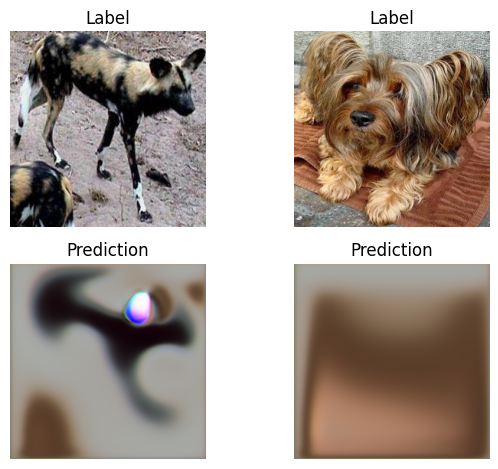

Epoch 200/1000, Recon Loss: 0.08049944043159485, KL Loss: 0.3927956819534302, Total Loss: 0.473295122385025


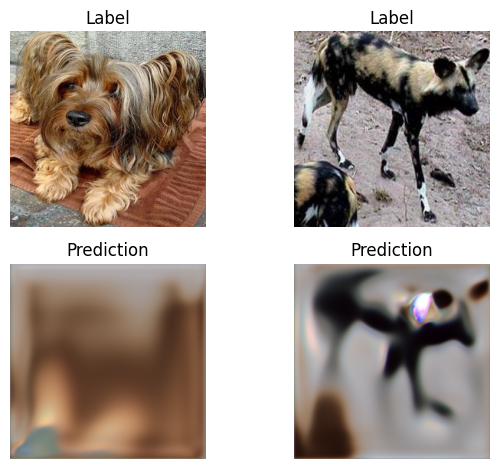

Epoch 300/1000, Recon Loss: 0.055095043033361435, KL Loss: 0.31944164633750916, Total Loss: 0.3745366930961609


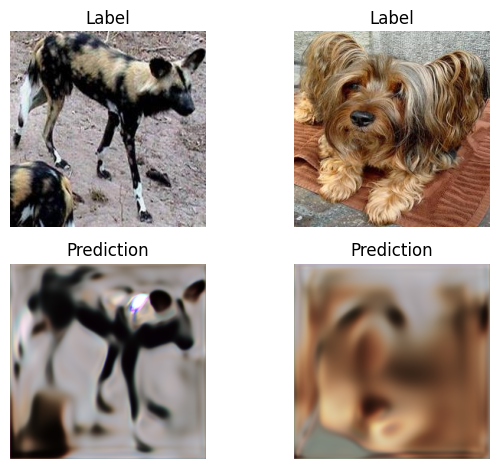

Epoch 400/1000, Recon Loss: 0.04713341221213341, KL Loss: 0.25809261202812195, Total Loss: 0.30522602796554565


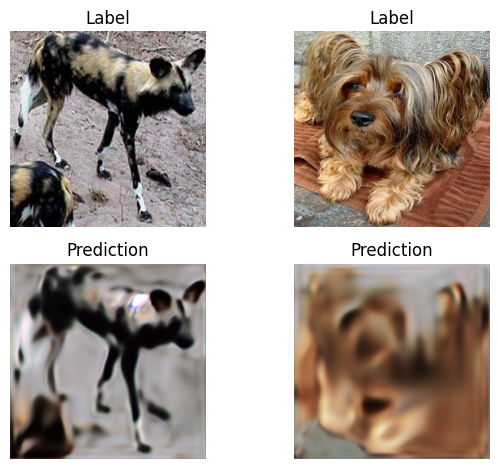

Epoch 500/1000, Recon Loss: 0.03688976168632507, KL Loss: 0.2061808556318283, Total Loss: 0.24307061731815338


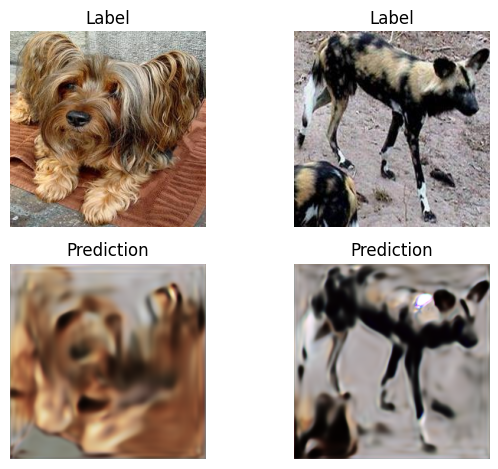

Epoch 600/1000, Recon Loss: 0.032037168741226196, KL Loss: 0.16296017169952393, Total Loss: 0.19499734044075012


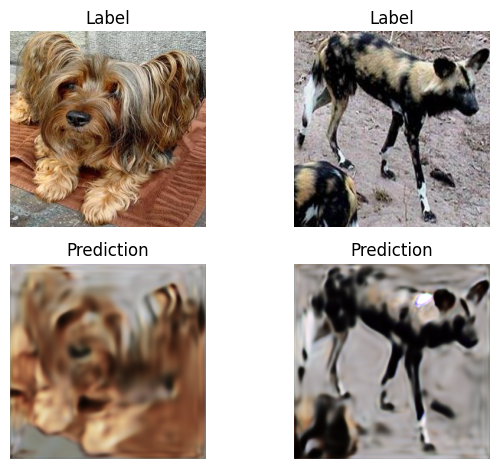

Epoch 700/1000, Recon Loss: 0.030762549489736557, KL Loss: 0.12723052501678467, Total Loss: 0.15799307823181152


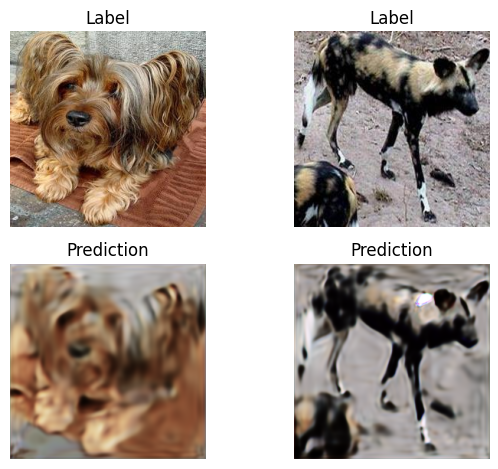

Epoch 800/1000, Recon Loss: 0.027588143944740295, KL Loss: 0.09794934093952179, Total Loss: 0.12553748488426208


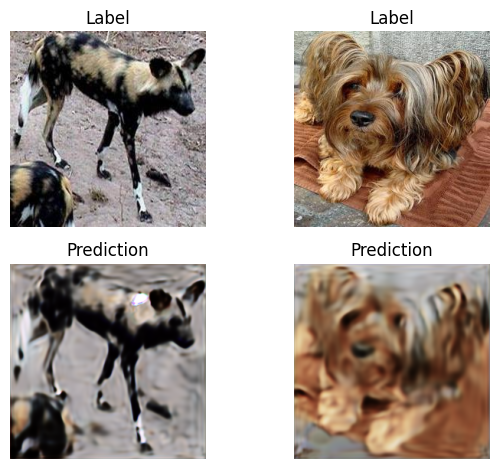

Epoch 900/1000, Recon Loss: 0.025602087378501892, KL Loss: 0.07425491511821747, Total Loss: 0.09985700249671936


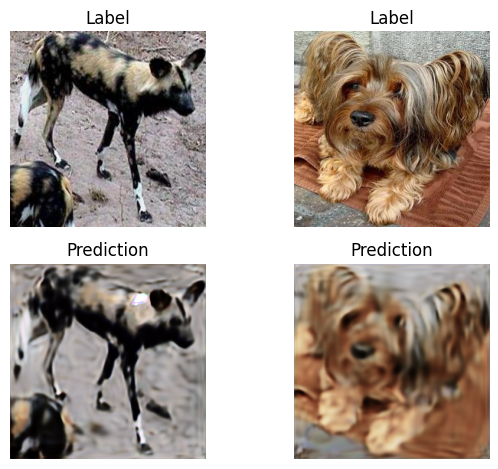

Epoch 1000/1000, Recon Loss: 0.024505972862243652, KL Loss: 0.05539990961551666, Total Loss: 0.07990588247776031


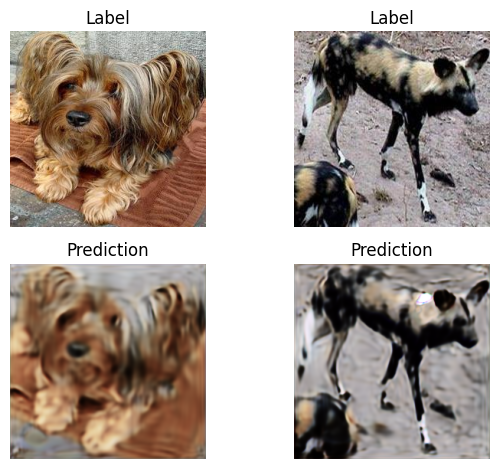

In [48]:
train_loader, val_loader, n_conditions = prepare_data("final_df.csv", batch_size=128)
# Create a tiny dataset with 2 examples
tiny_loader = DataLoader(
    torch.utils.data.Subset(train_loader.dataset, [0, 2]),  # Use first two examples
    batch_size=2,
    shuffle=True
)
# Adjust model capacity (optional, depends on results)
model = VAE(in_channels=3, feature_dim=256, latent_dim=512, cond_dim=32, n_conditions=n_conditions)
model = model.to('cuda')

# Train on a single batch
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
reconstruction_loss = nn.MSELoss()
epochs = 1000

for epoch in range(epochs):
    model.train()
    for data, condition, target in tiny_loader:
        data, condition, target = data.to('cuda'), condition.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, condition)
        recon_loss = reconstruction_loss(recon_batch, target)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

    # Visualize every 10 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Recon Loss: {recon_loss.item()}, KL Loss: {kl_loss.item()}, Total Loss: {loss.item()}")

        # Plot labels and predictions
        with torch.no_grad():
            recon_batch = denormalize(recon_batch)
            target = denormalize(target)
            recon_batch = recon_batch.clamp(0, 1).cpu()
            target = target.clamp(0, 1).cpu()
            for i in range(data.size(0)):
                plt.subplot(2, data.size(0), i + 1)
                plt.imshow(target[i].permute(1, 2, 0))
                plt.axis("off")
                plt.title("Label")
                plt.subplot(2, data.size(0), i + 1 + data.size(0))
                plt.imshow(recon_batch[i].permute(1, 2, 0))
                plt.axis("off")
                plt.title("Prediction")
        plt.tight_layout()
        plt.show()

# Training

In [51]:
# Initialize data and model
train_loader, val_loader, n_conditions = prepare_data("final_df.csv", batch_size=128)
model = VAE(in_channels=3, feature_dim=256, latent_dim=512, cond_dim=32, n_conditions=n_conditions)
print(f"VAE has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} Trainable Parameters")
# Train model and get loss history
train_losses, val_losses = train_vae(model, train_loader, val_loader, epochs=100, device='cuda', batch_size=128, n_conditions=n_conditions)

VAE has 28,446,595 Trainable Parameters


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Current beta is: tensor(1.)


Training Epoch 1:   0%|          | 0/139 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    fixed_z = torch.randn(1, model.latent_dim, 4, 4).to('cuda')
    fixed_cond = torch.randint(0, n_conditions, (1,1,)).to('cuda')
    
    cond_embedding = model.condition_ffn(model.condition_embeddings(fixed_cond).squeeze())
    cond_embedding = model.silu(cond_embedding)
    cond_embedding = cond_embedding.unsqueeze(-1).unsqueeze(-1).unsqueeze(0)  # (batch_size, cond_dim, 1, 1)
    cond_embedding = cond_embedding.expand(-1, -1, 4, 4)  # Expand for concatenation
    
    z_cond = torch.cat([fixed_z, cond_embedding], dim=1)
    generated = model.decoder(z_cond)
    generated = denormalize(generated)
    # Convert to image
    img = generated.squeeze().cpu().numpy().transpose(1, 2, 0)
    
    # Plot
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()